In [5]:
import pickle
import numpy as np

tsdir = '/home/anton/Documents/Tulane/Research/PNC_Good/'
demofile = '/home/anton/Documents/Tulane/Research/ImageNomer/data/anton/cohorts/PNC/demographics.pkl'
tsdict = dict()

for task in ['rest']:
    item = pickle.load(open(f'{tsdir}/PNC_SPM_{task}_good_filt.pkl', 'rb'))
    tsdict[task] = item
    
age = []
restsubs = []

demo = pickle.load(open(demofile, 'rb'))

for sub in demo['age_at_cnb']:
    try:
        tsr = tsdict['rest'][sub]
    except:
        continue
    a = demo['age_at_cnb'][sub]
    age.append(a)
    restsubs.append(sub)

age = np.array(age)

print([a.shape for a in [age]])
print(restsubs[:10])

[(1387,)]
['600001103037', '600009963128', '600018902293', '600020364885', '600020927179', '600031697545', '600038720566', '600039015048', '600039665619', '600045155842']


In [6]:
pickle.dump(nbacksubs, open('/home/anton/Documents/Tulane/Research/Work/DynamicDict/restsubs.pkl', 'wb'))

print('Done')

Done


In [94]:
# Load dynamic dict

rest = pickle.load(open('/home/anton/Documents/Tulane/Research/Work/DynamicDict/rest20-1.pkl', 'rb'))
A = rest['A']
w = rest['w']

Aflat = np.abs(np.concatenate(A))
print('Done')
print(Aflat.shape)

Done
(27740, 264)


In [95]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=128, n_init='auto').fit(Aflat)
cent = km.cluster_centers_

print(cent.shape)

(128, 264)


In [17]:
ours2orig = [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,
28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 254, 41, 42, 43, 44, 45,
46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64,
65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 85,
86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103,
104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 136, 138, 132,
133, 134, 135, 220, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152,
153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 185, 186,
187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201,
202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216,
217, 218, 219, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232,
233, 137, 234, 235, 236, 237, 238, 239, 240, 241, 250, 251, 255, 256, 257,
258, 259, 260, 261, 262, 263, 242, 243, 244, 245, 0, 1, 2, 3, 4, 5, 6, 7, 8,
9, 10, 11, 83, 84, 131, 139, 140, 141, 181, 182, 183, 184, 246, 247, 248,
249, 252, 253]

def vec2mat(v):
    a,b = np.triu_indices(264,1)
    m = np.zeros((264,264))
    m[a,b] = v
    return m+m.T

def remap(fc, roimap=ours2orig):
    fc = fc[roimap,:]
    fc = fc[:,roimap]
    return fc

print('Complete')

Complete


/tmp/ipykernel_47402/3602517066.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


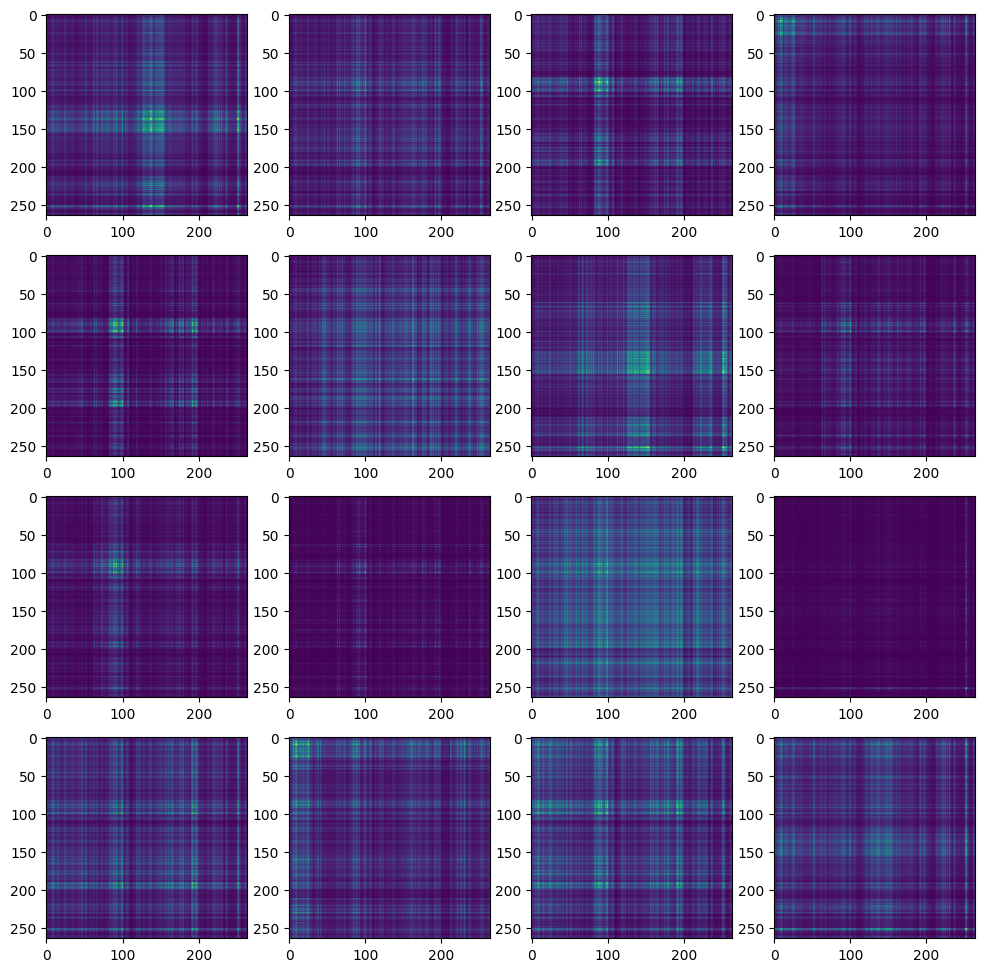

In [88]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(4,4,figsize=(12,12))

for i in range(4):
    for j in range(4):
        z0 = np.einsum('a,b->ab', cent[i*4+j], cent[i*4+j])
        ax[i,j].imshow(remap(z0))

fig.show()

In [96]:
AtoC = np.zeros((len(A), A[0].shape[0], cent.shape[0]))

for a in range(len(A)):
    for b in range(A[a].shape[0]):
        for c in range(cent.shape[0]):
            aa = A[a][b]-np.mean(A[a][b])
            xx = np.sum(aa**2)
            cc = cent[c]-np.mean(cent[c])
            yy = np.sum(cc**2)
            xy = np.abs(np.sum(aa*cc))
            AtoC[a,b,c] = xy/np.sqrt(xx*yy)
        
print('Complete')
print(AtoC.shape)

Complete
(1387, 20, 128)


In [84]:
AtoC[0,2]

array([0.00943007, 0.24709138, 0.18727577, 0.18069549, 0.27025029,
       0.19343588, 0.01621479, 0.21178652, 0.33209896, 0.26808977,
       0.13676453, 0.08226909, 0.13401102, 0.07118034, 0.0915025 ,
       0.08238321])

In [69]:
from scipy.special import softmax

AtoCpeak = softmax(AtoC*0.1)
print(AtoCpeak.shape)

(1387, 10, 64)


In [97]:
wRes = []

for a in range(len(w)):
    atcp = AtoC[a]
    ww = w[a]
    wres = np.einsum('dt,de->e',ww,atcp)
    wres = wres/np.sum(wres)
    wRes.append(wres)
    
wRes = np.stack(wRes)
print(wRes.shape)

(1387, 128)


In [59]:
wRes[3]

array([9.43216764e-03, 2.77856288e-03, 1.20393668e-03, 2.60315376e-03,
       4.89905847e-02, 1.08438461e-02, 3.47166792e-02, 1.39625895e-02,
       1.43093521e-04, 8.78251706e-03, 8.17415586e-03, 1.66891242e-04,
       1.03498491e-02, 1.09024518e-03, 1.09341077e-03, 1.11716079e-01,
       2.57769583e-02, 3.00588180e-03, 5.46892682e-05, 2.44808890e-03,
       5.26914794e-03, 1.20416712e-03, 2.05470711e-02, 3.22355455e-03,
       9.33291953e-04, 5.98564102e-03, 1.61366000e-03, 3.94427625e-02,
       1.25308898e-01, 1.71099505e-05, 2.33091961e-03, 1.08923400e-02,
       6.79605557e-03, 3.19689657e-02, 2.17677020e-03, 2.28556206e-01,
       6.75983581e-03, 3.44431309e-03, 1.29041933e-04, 8.04195335e-05,
       3.60914796e-04, 3.07542406e-04, 6.90208723e-05, 3.69707702e-02,
       2.40462314e-02, 1.12147452e-02, 1.91667277e-03, 1.43110452e-02,
       2.37487980e-03, 3.19417769e-04, 1.06450331e-02, 2.21843003e-02,
       1.40171449e-02, 1.03873745e-04, 3.11263121e-02, 1.49867144e-02,
      

In [60]:
print(age.shape)
print(wRes.shape)

(1387,)
(1387, 64)


In [100]:
def corr(x, y):
    x = x-np.mean(x, axis=0, keepdims=True)
    y = y-np.mean(y)
    xx = np.einsum('ab,ab->b', x, x)
    yy = np.einsum('a,a->', y, y)
    xy = np.einsum('ab,a->b', x, y)
    rho = xy/np.sqrt(xx*yy)
    return rho

corr(wRes, sex)

array([ 0.01817246,  0.03116963, -0.03070948,  0.01240712, -0.01559171,
       -0.05035842, -0.02585832, -0.04871147, -0.10094981, -0.02279763,
       -0.09331265, -0.02303555,  0.05644933, -0.21894031, -0.13178414,
        0.09111411, -0.00255887,  0.07604329,  0.08574366, -0.01269876,
       -0.04242657, -0.06080636,  0.09927341,  0.0920865 ,  0.07726952,
        0.08779044, -0.02081374,  0.00272247,  0.04412865,  0.05322613,
        0.03642323, -0.03129528,  0.0083014 ,  0.09070042, -0.02805057,
        0.11325714,  0.00698965, -0.05838868,  0.05945305,  0.00594354,
        0.08501262,  0.09569925,  0.08534727,  0.04938852, -0.02971665,
        0.04698613, -0.00524206, -0.05399267, -0.04991524,  0.11348879,
        0.06674213,  0.05334873,  0.04555913,  0.02249362,  0.02804858,
        0.11215845,  0.05792245,  0.05455791, -0.01982375, -0.00439642,
       -0.07778847,  0.09711986, -0.03065081,  0.02421539,  0.05223988,
       -0.08943712,  0.1068745 ,  0.01991451, -0.08362574, -0.02

In [79]:
sex = []

for sub in restsubs:
    try:
        s = demo['Race'][sub] == 'EA'
    except:
        s = 0
    sex.append(s)
    
sex = np.array(sex).astype('int')
print(sex.shape)

(1387,)


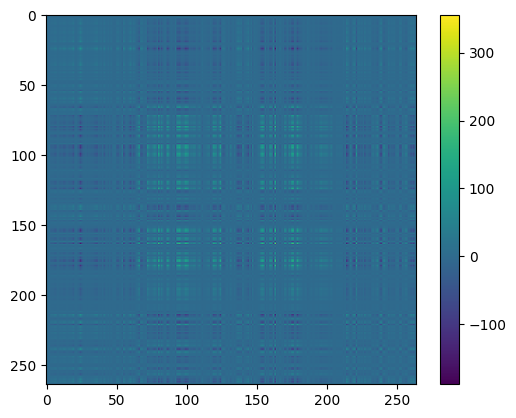

In [32]:
plt.imshow(remap(np.einsum('a,b->ab',A[0][2],A[0][2])))
plt.colorbar()
plt.show()